# データセット、ライブラリの準備

In [22]:
import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

#データ読み込み
df_simple_1 = pd.read_csv("C:\\Users\\hayashi\\Desktop\\Nocturne_Op._32_No._2_right.csv",encoding="utf-8",parse_dates=True)#対応付けデータ
df_simple_2 = pd.read_csv("C:\\Users\\hayashi\\Desktop\\Prlude_Opus_28_No._15_in_D_Major__Chopin_right.csv",encoding="utf-8",parse_dates=True)
df_simple_3 = pd.read_csv("C:\\Users\\hayashi\\Desktop\\Waltz_in_C_Minor_Op_64_No_2_right.csv",encoding="utf-8",parse_dates=True)
df_simple_4 = pd.read_csv("C:\\Users\\hayashi\\Desktop\\Waltz_Opus_69_No._1_in_A_Major_right.csv",encoding="utf-8",parse_dates=True)
df_simple_5 = pd.read_csv("C:\\Users\\hayashi\\Desktop\\Chopin_Etude_Op._25_No._11_A_right.csv",encoding="utf-8",parse_dates=True)

df_simple_1.replace({'Dyn': {'pp': 32,'p': 48,'mp': 64,'non': 72,'mf': 80,'sf': 112,'f': 96,'ff': 112}},inplace=True) #k強弱記号を数値に変換
df_simple_2.replace({'Dyn': {'pp': 32,'p': 48,'mp': 64,'non': 72,'mf': 80,'sf': 112,'f': 96,'ff': 112}},inplace=True)
df_simple_3.replace({'Dyn': {'pp': 32,'p': 48,'mp': 64,'non': 72,'mf': 80,'sf': 112,'f': 96,'ff': 112}},inplace=True)
df_simple_4.replace({'Dyn': {'pp': 32,'p': 48,'mp': 64,'non': 72,'mf': 80,'sf': 112,'f': 96,'ff': 112}},inplace=True)
df_simple_5.replace({'Dyn': {'pp': 32,'p': 48,'mp': 64,'non': 72,'mf': 80,'sf': 112,'f': 96,'ff': 112}},inplace=True)

dfa_1 = df_simple_1[["Key","Tgate","Tstep","Dyn","Velo","Step","Gate"]] #対象を絞る
dfa_2 = df_simple_2[["Key","Tgate","Tstep","Dyn","Velo","Step","Gate"]] 
dfa_3 = df_simple_3[["Key","Tgate","Tstep","Dyn","Velo","Step","Gate"]] 
dfa_4 = df_simple_4[["Key","Tgate","Tstep","Dyn","Velo","Step","Gate"]] 
dfa_5 = df_simple_5[["Key","Tgate","Tstep","Dyn","Velo","Step","Gate"]]

df_1 = dfa_1.loc[:, ["Key","Tgate","Tstep","Dyn","Velo","Gate","Step"]] #順序を入れ替え
df_2 = dfa_2.loc[:, ["Key","Tgate","Tstep","Dyn","Velo","Gate","Step"]]
df_3 = dfa_3.loc[:, ["Key","Tgate","Tstep","Dyn","Velo","Gate","Step"]] 
df_4 = dfa_4.loc[:, ["Key","Tgate","Tstep","Dyn","Velo","Gate","Step"]] 
df_5 = dfa_5.loc[:, ["Key","Tgate","Tstep","Dyn","Velo","Gate","Step"]] 

df_1.fillna(0, inplace=True) #空白を0で埋める
df_2.fillna(0, inplace=True)
df_3.fillna(0, inplace=True)
df_4.fillna(0, inplace=True)
df_5.fillna(0, inplace=True)
print(type(df_1))

# #0〜1にスケーリング
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df_scale_1 = pd.DataFrame(scaler.fit_transform(df_1),index=df_1.index,columns=df_1.columns)
df_scale_2 = pd.DataFrame(scaler.fit_transform(df_2),index=df_2.index,columns=df_2.columns)
df_scale_3 = pd.DataFrame(scaler.fit_transform(df_3),index=df_3.index,columns=df_3.columns)
df_scale_4 = pd.DataFrame(scaler.fit_transform(df_4),index=df_4.index,columns=df_4.columns)
df_scale_5 = pd.DataFrame(scaler.fit_transform(df_5),index=df_5.index,columns=df_5.columns)

#訓練データとテストデータに分割
#df_scale_train = df_scale[0:700]
#df_scale_test = df_scale[701:1252]

<class 'pandas.core.frame.DataFrame'>


In [5]:
df_scale_2

,Key,Tgate,Tstep,Dyn,Velo,Gate,Step
0,0.807692,0.166667,0.186228,0.2,0.317073,0.241754,0.271458
1,0.653846,0.038462,0.061033,0.2,0.158537,0.086988,0.075668
2,0.461538,0.487179,0.499218,0.2,0.329268,0.291591,0.366517
3,0.538462,0.230769,0.248826,0.2,0.475610,0.169627,0.184440
4,0.615385,0.743590,0.749609,0.2,0.451220,0.457412,0.542206
...,...,...,...,...,...,...,...
561,0.000000,0.102564,0.123631,0.0,0.256098,0.069772,0.099077
562,0.000000,0.102564,0.123631,0.0,0.231707,0.114534,0.164105
563,0.000000,0.102564,0.123631,0.0,0.365854,1.000000,0.171672
564,0.000000,0.102564,0.123631,0.0,0.231707,0.987495,0.171672


# RNN用データへの成形

CSVファイルから読み込んだDataFrame型のデータを学習用のデータセットに成形  
時系列データから入力データと正解データのセットを作る


例  

1～4小節目を学習( x1～x4 )→5小節目を出力( f(x1～x4) )　正解:x5  
2～5小節目を学習( x2～x5 )→6小節目を出力( f(x2～x5) )　正解:x6

→必要に応じて正規化(データの値を0～1にスケーリング)する

In [24]:
look_back = 30 #どれくらい過去まで見るか

def create_input_data(df_scale, look_back):    
    
    df_OMD_train = df_scale[["Gate","Step","Velo"]] #Gate,Step→　目的変数
    df_TMD_train = df_scale[["Tgate","Tstep","Dyn"]] #Tgate,Tstep→　説明変数
    
    raw_data_x = df_TMD_train.T.values.tolist()
    raw_data_y = df_OMD_train.T.values.tolist()
    data_size = max(len(df_TMD_train), len( df_OMD_train)) - look_back
    raw_data_size = len(max(raw_data_x, raw_data_y))
    
    X = [[] for i in range(len(raw_data_x))] 
    y = [[] for i in range(len(raw_data_y))] 


    for i in range(data_size):
        for j in range(raw_data_size):
            X[j].append(raw_data_x[j][i:i + look_back])
            y[j].append([raw_data_y[j][i + look_back]])

    X_tmp = X[-1]
    y_tmp = y[-1]
    
    for i in range(raw_data_size-1):
        X_tmp = np.insert(X_tmp,np.arange(0, (look_back-1)*(i+1)+1, i+1),X[-i-2],axis=1)
        y_tmp = np.insert(y_tmp,np.arange(0, (i+1), i+1),y[-i-2],axis=1)
    
    X = np.array(X_tmp).reshape(data_size, look_back, len(raw_data_x))
    y = np.array(y_tmp).reshape(data_size, 1, len(raw_data_y))
    
    return y, X

y_train_1,X_train_1 = create_input_data(
    df_scale = df_scale_1,   
    look_back = look_back
)

y_train_2,X_train_2 = create_input_data(
    df_scale = df_scale_2,   
    look_back = look_back
)

y_train_3,X_train_3 = create_input_data(
    df_scale = df_scale_3,   
    look_back = look_back
)

y_train_4,X_train_4 = create_input_data(
    df_scale = df_scale_4,   
    look_back = look_back
)

y_test,X_test = create_input_data(
    df_scale = df_scale_5,   
    look_back = look_back#テストデータ
)
#x_data=df_TMD_train,
#y_data=df_OMD_train,


In [25]:
X_train_1.shape[2]

3

# モデルの定義

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

model = Sequential()
x = model.add(LSTM(10,return_sequences=True, input_shape=(30, X_train_1.shape[2])))#ユニット数10 #inpyut_shapeは（look_back、入力の次元数）
model.add(LSTM(8))
model.add(Dense(3)) #全結合層 #出力層はデータ数に合わせる(目的変数の次元数)

model.compile(loss='mean_squared_error', optimizer='adam')#adam:最適化アルゴリズム

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 10)            560       
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 608       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 1,195
Trainable params: 1,195
Non-trainable params: 0
_________________________________________________________________


# 学習

In [28]:
history1 = model.fit(X_train_1, y_train_1, epochs=1000, batch_size=1)
history2 = model.fit(X_train_2, y_train_2, epochs=1000, batch_size=1)
history3 = model.fit(X_train_3, y_train_3, epochs=1000, batch_size=1)
history4 = model.fit(X_train_4, y_train_4, epochs=1000, batch_size=1)
# history5 = model.fit(X_train_5, y_train_5, epochs=1000, batch_size=1)

Epoch 1/1000
659/659 [==============================] - 6s 7ms/step - loss: 0.0154
Epoch 2/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0133
Epoch 3/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0132
Epoch 4/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0132
Epoch 5/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0131
Epoch 6/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0131A: 0
Epoch 7/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0130
Epoch 8/1000
659/659 [==============================] - 5s 7ms/step - loss: 0.0131A: 0s - los
Epoch 9/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0130
Epoch 10/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0132
Epoch 11/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0130
Epoch 12/1000
659/659 [==============================] - 4s 7ms/step -

659/659 [==============================] - 4s 6ms/step - loss: 0.0085
Epoch 95/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0084
Epoch 96/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0086
Epoch 97/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0083
Epoch 98/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0082
Epoch 99/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0082
Epoch 100/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0080A: 0s
Epoch 101/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0083A: 0s - loss: 0
Epoch 102/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0082
Epoch 103/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0081
Epoch 104/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0082A: 0s - loss: 0
Epoch 105/1000
659/659 [==========================

659/659 [==============================] - 4s 7ms/step - loss: 0.0073
Epoch 185/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0070
Epoch 186/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0069A: 0s - los - ETA: 0s - loss: 0.007
Epoch 187/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0071 ETA: 1s - loss: 0.
Epoch 188/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0072A: 0s - loss: - ETA: 0s - lo
Epoch 189/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0070
Epoch 190/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0069
Epoch 191/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0071
Epoch 192/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0070A: 0s - loss: 
Epoch 193/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0071
Epoch 194/1000
659/659 [==============================] - 4s 7ms/step

659/659 [==============================] - 5s 7ms/step - loss: 0.0060A: 1s - loss:  
Epoch 274/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0060A:
Epoch 275/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0060
Epoch 276/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0067
Epoch 277/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0063
Epoch 278/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0061A: 3s - lo - ETA: 2s - loss: -
Epoch 279/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0059
Epoch 280/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0073A: 
Epoch 281/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0070
Epoch 282/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0062
Epoch 283/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0061
Epoch 284/1000
659/659 [======

659/659 [==============================] - 5s 7ms/step - loss: 0.0054
Epoch 367/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0053
Epoch 368/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0053
Epoch 369/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0052
Epoch 370/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0053A: 1s - l - ETA: 0s - los
Epoch 371/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0053
Epoch 372/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0052
Epoch 373/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0053
Epoch 374/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0053
Epoch 375/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0052A: 0s - loss: 0.
Epoch 376/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0053A: 0s - loss: 0.0 - ETA: 0s - loss:
Epoc

659/659 [==============================] - 4s 6ms/step - loss: 0.0048A: 2s - lo - ETA: 0s - loss:
Epoch 455/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0046
Epoch 456/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0048A - ETA: 3s  - 
Epoch 457/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0047
Epoch 458/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0046A: 3s - ETA: 2s -  - ETA: 1s - - 
Epoch 459/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0047A: 3s - loss:  - ETA:
Epoch 460/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0049A: 0s - loss: 0
Epoch 461/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0047A: 0s 
Epoch 462/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0050A: 1s - loss: 0 - ETA: 0s
Epoch 463/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0049A:
Epoch 464/1000
659/6

659/659 [==============================] - 4s 6ms/step - loss: 0.0045- ETA: 4s -  - ETA: 3s - - ETA: 0s - loss: 0.004
Epoch 536/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0043A: 2s -  - ETA: 2s -  - ETA: 0s - loss
Epoch 537/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0047A: 0s - loss
Epoch 538/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0046A: - ETA: 0s - loss: 0.0
Epoch 539/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0043A: 3s - loss: 0.0 - ETA: 3s - loss:   - ETA: 1 - ETA: 1s - loss: - ETA: 0s 
Epoch 540/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0043TA: 3s - loss: 0. - ETA: 3s - l - ETA: 3s  - ETA: 2 - ETA: 1s - loss: 0.00 - ETA: 1s - loss:  - ETA: 1s - los - ETA: 0
Epoch 541/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0043
Epoch 542/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0043
Epoch 543/1000
659/6

659/659 [==============================] - 4s 6ms/step - loss: 0.0042TA: 3s -  - ETA: 0s - loss: 0. - ETA: 0s - l
Epoch 609/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0042A: 1s - loss: 0.0 - ETA: 1s - loss: - ETA: 
Epoch 610/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0042A: 2s - loss: 0.0 - ETA: 2s - loss - ETA: 0s - 
Epoch 611/1000
659/659 [==============================] - ETA: 0s - loss: 0.0041- ETA: 0s - loss: 0.0 - ETA: 0s - loss: - ETA: 0s - loss: - 4s 6ms/step - loss: 0.0041
Epoch 612/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0043
Epoch 613/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0042
Epoch 614/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0041A: 0s - loss: 0.00
Epoch 615/1000
659/659 [==============================] - ETA: 0s - loss: 0.0042- ETA: 3s - los - ETA: 0s  - 4s 6ms/step - loss: 0.0041
Epoch 616/1000
659/659 [==========================

659/659 [==============================] - 4s 6ms/step - loss: 0.0041A: 0s - loss: 0. - ETA: 0s - loss: 0.0 - ETA: 0s - loss
Epoch 679/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0041A: 2s - loss: 0. - ET - ETA: 0s - loss: 0.00
Epoch 680/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0040A: 0s - los
Epoch 681/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0048A: 3s -  - ETA: 3s - loss: - ETA: 2s - loss: 0.0 - ETA: 2s - los - ETA: 2s - E - ETA: 0s - loss: - ETA: 0s - loss: 0.00
Epoch 682/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0041A: 0s - loss: 0
Epoch 683/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0040- ETA: 4s - loss: 0. - ETA: 3s - los - ETA: 3s - loss -  - ETA: 1s - loss: 0.00 - ETA: 1s - - ETA: 1s - los - ETA: 0s - loss - ETA: 0s - loss: 0
Epoch 684/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0040
Epoch 685/1000
659/659 [========

659/659 [==============================] - 4s 6ms/step - loss: 0.0040A: 0s - l - ETA: 0s - loss
Epoch 748/1000
659/659 [==============================] - ETA: 0s - loss: 0.0040- ET - 4s 6ms/step - loss: 0.0040
Epoch 749/1000
659/659 [==============================] - ETA: 0s - loss: 0.0039- ETA:  - ETA: 1s - lo - ETA: 1 - ETA: 0s - loss:  - 4s 6ms/step - loss: 0.0039
Epoch 750/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0039
Epoch 751/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0042A: 0s - loss: 0.0
Epoch 752/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0040 ETA: 1s  - ETA: 0s - loss: 
Epoch 753/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0040A: 1s - ETA: 0s - loss: 
Epoch 754/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0040A: 4s - loss: - ETA: 1s - loss: 0.004 -
Epoch 755/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0040
Epoch 756/10

659/659 [==============================] - 4s 6ms/step - loss: 0.0038A: - ETA: 0s - loss - ETA: 0s - loss: 0.0
Epoch 818/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0038A: 2s - loss:  - ETA: 2s - loss: 0. - ETA: 2s - loss: 0. - ETA: -
Epoch 819/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0039A: 3s  
Epoch 820/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0039A: 1s - loss: 0.0 - ETA: 0s - loss: 0.00 - ETA: 
Epoch 821/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0039A: - ETA: 0s - loss: 0. - ETA: 0s - loss: 0. - ETA: 0s - loss:  - ETA: 0s - loss: 0.
Epoch 822/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0039
Epoch 823/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0039A: 0s 
Epoch 824/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0039A: 1s - los - ETA: 0s - loss:  - ETA: 0s - loss: 0.004 - ETA: 0s - 
Epoch 825/1000
65

659/659 [==============================] - 4s 7ms/step - loss: 0.0039A: 3s - loss: 0.00 - E - ETA: 1s - los
Epoch 894/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0038
Epoch 895/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0037A: 2 - ETA: 0s - loss: 0.0 - ETA: 0s -
Epoch 896/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0038A: 3s - loss: 0. - - ETA: 0s 
Epoch 897/1000
659/659 [==============================] - 4s 7ms/step - loss: 0.0039
Epoch 898/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0038
Epoch 899/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0039
Epoch 900/1000
659/659 [==============================] - ETA: 0s - loss: 0.0037- ETA: - 4s 6ms/step - loss: 0.0037
Epoch 901/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0038
Epoch 902/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0038A: 2s - loss: - ETA: - ETA: 1s

659/659 [==============================] - 4s 6ms/step - loss: 0.0037
Epoch 975/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0037A: 1s - l - ETA: 0s 
Epoch 976/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0038
Epoch 977/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0038
Epoch 978/1000
659/659 [==============================] - ETA: 0s - loss: 0.0038- ETA: - 4s 6ms/step - loss: 0.0038
Epoch 979/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0038A: 1s - loss: 0. - ETA:  - ETA: 0s - loss: 0.00
Epoch 980/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0037A: 1s - loss: 0 - ETA: 0s - loss - ETA: 0s - loss: 0.00 - ETA: 0s - loss
Epoch 981/1000
659/659 [==============================] - 4s 6ms/step - loss: 0.0037A: 1s - loss: - ETA: 1s - l - ETA: 0s - loss: - ETA: 0s - loss:
Epoch 982/1000
659/659 [==============================] - ETA: 0s - loss: 0.0039- ETA: 1s - lo - ETA: 

536/536 [==============================] - 3s 6ms/step - loss: 0.0143A: 1s - loss: 0.0 
Epoch 47/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0143A: 3
Epoch 48/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0143A: 1s  -
Epoch 49/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0143A: 1s - loss: 0 - ETA: 0s - loss:
Epoch 50/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0144A: 3s - loss: 0 - ETA - ETA: 
Epoch 51/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0142A: 0s
Epoch 52/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0142A: 0s - lo
Epoch 53/1000
536/536 [==============================] - ETA: 0s - loss: 0.0139- ETA: - 3s 6ms/step - loss: 0.0139
Epoch 54/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0138 ETA: 0s - loss:  - ETA: 0s - loss: 
Epoch 55/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0137A

536/536 [==============================] - 3s 6ms/step - loss: 0.0129A: 2s - loss:  - ETA: 2s - - ETA: 1s - l
Epoch 122/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0125A: 2s - loss: 0.0 - ETA: 2s - loss: 0 - ETA - ETA: 1 - ETA: 0s - loss: 
Epoch 123/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0128A: 0s - loss - ETA: 0s - los
Epoch 124/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0126A: - ETA: 0s - loss: 0.0
Epoch 125/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0129- ETA: 2s - - ETA: 0s - loss:
Epoch 126/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0127A: 2s - loss: 0.0 - ETA: 2s - loss: 0.0 - ETA: 2s - lo - ETA: 1s - loss
Epoch 127/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0126A: 2s - loss: 0 - ETA: - E
Epoch 128/1000
536/536 [==============================] - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - 3s 6ms/step - loss: 0.012

536/536 [==============================] - 3s 6ms/step - loss: 0.0118A: 0s - l
Epoch 189/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0115A: 3s
Epoch 190/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0115A: 3s - loss: 0.0 - ET - ETA: 2s
Epoch 191/1000
536/536 [==============================] - ETA: 0s - loss: 0.011 - 3s 6ms/step - loss: 0.0117
Epoch 192/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0114A: 0
Epoch 193/1000
536/536 [==============================] - ETA: 0s - loss: 0.0118- ETA: 2s - lo - ETA: 2s - loss: 0.0 - E - ETA: 0s - loss: 0.01 - ETA: 0s  - 3s 6ms/step - loss: 0.0118
Epoch 194/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0116A: 0s -
Epoch 195/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0118A: 0s - loss: 0 - ETA: 0s - loss: 
Epoch 196/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0131A: 3s - los - ETA: 2s - loss: 0.0 - E

536/536 [==============================] - 3s 6ms/step - loss: 0.0116A: 2s - loss - E
Epoch 262/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0117A: 1s - loss: 0.01 - ETA: 1s - l - ETA
Epoch 263/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0114A: 3s - l - ETA: 2 - ETA: - ETA: 1s - l - ETA: 0s - lo
Epoch 264/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0111A: 1s - loss:  - ETA: 1s -  - ET
Epoch 265/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0114A:  - ETA: 2s - loss: 0.  - ETA: 0s -  - ETA: 0s - loss
Epoch 266/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0110
Epoch 267/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0111A: 1s - loss - ETA: 1s  - ETA: 0s - l
Epoch 268/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0109 - ETA: 0s -  - ETA: 0s - loss: 0.01
Epoch 269/1000
536/536 [==============================] - 3s 6ms/st

536/536 [==============================] - 3s 6ms/step - loss: 0.0103A: 3s
Epoch 336/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0100A: 0s - loss: 0.
Epoch 337/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0103A: 0s - loss: 0.01 - ETA: 0s - los
Epoch 338/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0098
Epoch 339/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0101A: 3s - ETA: 2s - loss: 0.010 - ETA: 2s - lo - ETA: 0s -
Epoch 340/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0104A:
Epoch 341/1000
536/536 [==============================] - ETA: 0s - loss: 0.0100- ETA: 0s - l - 3s 6ms/step - loss: 0.0099
Epoch 342/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0100
Epoch 343/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0100
Epoch 344/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0101A: - E
Epoch 34

536/536 [==============================] - 3s 6ms/step - loss: 0.0093 ETA: 1s - loss:  - ETA: 1s - loss: 0.0 - ETA: 1s - loss: 0. -
Epoch 411/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0095A: 2s - l - ETA: 0s 
Epoch 412/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0093ETA: 0s - loss: - ETA: 0s - loss: 0.00
Epoch 413/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0100
Epoch 414/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0096A: 0s - loss: 0.009
Epoch 415/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0100A: 1s - loss: 0. - ETA: 0s - - ETA: 0s - loss: 0.0
Epoch 416/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0093A: 0s - 
Epoch 417/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0094A: 0s - los - ETA: 0s - loss: 0.00 - ETA: 0s - loss: 0.00
Epoch 418/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0

536/536 [==============================] - 3s 6ms/step - loss: 0.0110A: 0s - loss: 0.011 - ETA: 0s - loss: 0
Epoch 488/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0104
Epoch 489/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0100A: 0s - loss: - ETA: 0s - loss: 0
Epoch 490/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0098A: 
Epoch 491/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0103
Epoch 492/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0098A: 3s  - ETA: 2s - loss - E - 
Epoch 493/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0096
Epoch 494/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0098A: 2s - - ETA: 0s - loss: 0.00
Epoch 495/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0098
Epoch 496/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0095 ETA: 0s 
Epoch 497/1000
536/53

536/536 [==============================] - 3s 6ms/step - loss: 0.0083- ETA: 3s - loss: -  - ET - ETA: 0s - loss:  - ETA: 0s - los
Epoch 563/1000
536/536 [==============================] - 4s 7ms/step - loss: 0.0090ETA: 0s - loss: 0.
Epoch 564/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0094A: 3s - lo - ETA: 0s - loss: 0.00
Epoch 565/1000
536/536 [==============================] - ETA: 0s - loss: 0.0086- ET - ETA: 1s - loss: 0.009 - ETA: 1s - los - ETA: 1s - loss: 0.008 - ETA: 1s - ETA: 0s - loss:  - 3s 6ms/step - loss: 0.0085
Epoch 566/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0084
Epoch 567/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0084A: 1s - loss: 
Epoch 568/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0083
Epoch 569/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0082
Epoch 570/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0086A: 1

536/536 [==============================] - 3s 6ms/step - loss: 0.0080A: 3s - loss: 0. - ETA: 2s - loss: 0.0 - ETA: 2s - loss:  - ETA:  - ETA: 1s - loss:  - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0. - ETA: 1s - loss: 0.00 - ETA: 0s - loss: 0. - ETA: 0s 
Epoch 632/1000
536/536 [==============================] - 3s 7ms/step - loss: 0.0082
Epoch 633/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0084
Epoch 634/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0083A: 0s - los
Epoch 635/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0081
Epoch 636/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0082A: 3s - loss: - ETA: 2s - loss: 0. - ETA: - E - ETA: 0s 
Epoch 637/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0080A: 3 - ETA: 2s - los - ETA:  - ETA: 0s - loss:  - ETA: 0s - 
Epoch 638/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0085A: 2s - los - ETA: 0s - l

536/536 [==============================] - 3s 6ms/step - loss: 0.0078- ETA: 3s - loss: 0.0 - ETA: 3s - l - ETA: 2s - - ETA: 0s -
Epoch 705/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0078 ETA: 3 - ETA: 2s - loss: - ETA: 0s - loss: - ETA: 0s - loss: - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007
Epoch 706/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0080- ETA: 2s - loss: - ETA: 0s -
Epoch 707/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0080A: 1s - loss
Epoch 708/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0078A: 2s - loss: 0.008 - ETA
Epoch 709/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0083A: 0s - loss: 0.008
Epoch 710/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0076
Epoch 711/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0074A: 3s - loss: 0.0 - ETA: 3s - loss: 0.0 -  - ETA: 1s - 
Epoch 712/1000
536/536 [===

536/536 [==============================] - ETA: 0s - loss: 0.0078 - ETA: 3s - loss: 0.006 - ETA: 3s - lo - ETA: 2s - loss - ETA - ETA: 1s - - ETA: 0s - loss:  - ETA: 0s - loss: 0 - 3s 6ms/step - loss: 0.0078
Epoch 779/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0077A: 0s - loss: 0.00
Epoch 780/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0074 ETA: 0 - ETA: 0s - loss: 0.00
Epoch 781/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0072
Epoch 782/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0090
Epoch 783/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0172A: 3s - loss: 0 - ETA: 3s - lo
Epoch 784/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0150A:
Epoch 785/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0139A: 2s - - ETA: 0s 
Epoch 786/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0133A: 1s - loss: 0

536/536 [==============================] - 3s 6ms/step - loss: 0.0096A:  - ETA: 
Epoch 856/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0103A: 1s - loss: 0 - ETA: 1s - loss:  - ETA: 1s - l - ETA: 0s - loss: 0.010 - ETA: 0s - los
Epoch 857/1000
536/536 [==============================] - ETA: 0s - loss: 0.012 - 3s 6ms/step - loss: 0.0120
Epoch 858/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0117A: 3s - loss: 0 - ETA: 3s - loss: 0.0 - ETA: - ETA: 2s - loss:   - ETA: 0s - lo
Epoch 859/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0111A: 0s - loss:
Epoch 860/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0111
Epoch 861/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0108
Epoch 862/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0110
Epoch 863/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0106A: 2s  - ETA: 1s - loss: 0. - ETA: 1

536/536 [==============================] - 3s 6ms/step - loss: 0.0086A: 3s - l - ETA: 2s - loss: 0.0 - ETA - ETA: 0s - loss: 
Epoch 931/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0084A:
Epoch 932/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0087A: 2s -  - E
Epoch 933/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0089A: 3 - ETA: 1s - - ETA: 0s - lo
Epoch 934/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0085TA: - ETA: 0s - 
Epoch 935/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0086
Epoch 936/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0088A: 3s - loss - ETA: 2s - loss: 0.0 - ET - ETA: 0s - loss: 0
Epoch 937/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0084A: 2s - los - ETA: 2s - loss: 0.0 - E - ETA: 0s - l - ETA: 0s - loss
Epoch 938/1000
536/536 [==============================] - 3s 6ms/step - loss: 0.0083A: 3s  

833/833 [==============================] - 5s 6ms/step - loss: 0.0134A: 3s - loss: 0. - ETA: 3s - loss: 0 - ETA: 3s - l - ETA: 1s - - ETA: 0s - l
Epoch 2/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0084A: 2s - loss: - ETA: 1s - los - ETA: 0s - loss: 0
Epoch 3/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0075A: 1s -   - ETA: 0s - loss: 0.0
Epoch 4/1000
833/833 [==============================] - ETA: 0s - loss: 0.0071  - ETA: 5s - loss: 0.0 - ETA: 5s - loss: - ETA: 2s - 5s 6ms/step - loss: 0.0070
Epoch 5/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0069A: 2s - loss: - ETA: 2 - ETA: 1s - ETA: 0s - los - ETA: 0s - loss: 0.00
Epoch 6/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0066A: 4s - loss: 0.00 - ETA: 4s - loss: - E - ETA: 0s - loss: 0.00 - ETA: 0s - loss
Epoch 7/1000
833/833 [==============================] - 6s 7ms/step - loss: 0.0065
Epoch 8/1000
833/833 [===========================

833/833 [==============================] - 5s 6ms/step - loss: 0.0043
Epoch 90/1000
833/833 [==============================] - 5s 7ms/step - loss: 0.0045
Epoch 91/1000
833/833 [==============================] - 5s 7ms/step - loss: 0.0046A: 0s - loss: 0
Epoch 92/1000
833/833 [==============================] - 5s 7ms/step - loss: 0.0044A
Epoch 93/1000
833/833 [==============================] - 5s 7ms/step - loss: 0.0045A: 0s -
Epoch 94/1000
833/833 [==============================] - 5s 7ms/step - loss: 0.0043
Epoch 95/1000
833/833 [==============================] - 5s 7ms/step - loss: 0.0043
Epoch 96/1000
833/833 [==============================] - 5s 7ms/step - loss: 0.0045
Epoch 97/1000
833/833 [==============================] - 5s 7ms/step - loss: 0.0044
Epoch 98/1000
833/833 [==============================] - 5s 7ms/step - loss: 0.0044
Epoch 99/1000
833/833 [==============================] - 5s 7ms/step - loss: 0.0043
Epoch 100/1000
833/833 [==============================] - 5s 6ms/st

833/833 [==============================] - 5s 7ms/step - loss: 0.0040A: 1s - loss: - ETA: 1s - loss: 0.0 - ETA
Epoch 180/1000
833/833 [==============================] - 5s 7ms/step - loss: 0.0040
Epoch 181/1000
833/833 [==============================] - 5s 7ms/step - loss: 0.0041
Epoch 182/1000
833/833 [==============================] - 5s 7ms/step - loss: 0.0040
Epoch 183/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0040
Epoch 184/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0037
Epoch 185/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0037
Epoch 186/1000
833/833 [==============================] - ETA: 0s - loss: 0.0037- ETA: 0s - l - 5s 6ms/step - loss: 0.0037
Epoch 187/1000
833/833 [==============================] - 5s 7ms/step - loss: 0.0038A: 0s - los
Epoch 188/1000
833/833 [==============================] - 5s 7ms/step - loss: 0.0037
Epoch 189/1000
833/833 [==============================] - 5s 6ms/step - los

833/833 [==============================] - 5s 6ms/step - loss: 0.0036A: 0s - los
Epoch 261/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0035
Epoch 262/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0032
Epoch 263/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0032 ETA: 0s - loss: 0.
Epoch 264/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0033
Epoch 265/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0033A: 0s - loss: 0
Epoch 266/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0033
Epoch 267/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0031A: 0s - loss:
Epoch 268/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0033 - ETA: 1s - loss: 0.0 - E
Epoch 269/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0032A: 0s - l - ETA: 0s - loss
Epoch 270/1000
833/833 [==============================]

833/833 [==============================] - 5s 6ms/step - loss: 0.0030
Epoch 337/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0031- ETA: 0s - loss: 0.00
Epoch 338/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0031A: 5s - loss: 0.00 - E - ETA: 4s - - ETA -
Epoch 339/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0029
Epoch 340/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0030
Epoch 341/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0031A: 0s - loss
Epoch 342/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0030
Epoch 343/1000
833/833 [==============================] - ETA: 0s - loss: 0.0035- ETA: 0s - loss: 0.00 - 5s 6ms/step - loss: 0.0035
Epoch 344/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0033
Epoch 345/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0029A: 4s - loss - ETA: 4s - ETA: 3s - l - ETA:

833/833 [==============================] - 5s 6ms/step - loss: 0.0028A: 4s - loss:  - ETA: 0s 
Epoch 401/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0028 - ETA - ETA: 0s - loss: 0.00
Epoch 402/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0028
Epoch 403/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0029A:
Epoch 404/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0028
Epoch 405/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0029ETA: 5s - loss: 0.002 - ETA: 4s - loss: 0. - ET - ETA:  - ETA: 1s - loss: 0.002 - ETA: 1s - loss: 0
Epoch 406/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0030A: 0s - lo - ETA: 0s - loss: 
Epoch 407/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0028
Epoch 408/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0027
Epoch 409/1000
833/833 [==============================] - 5s 6ms/s

833/833 [==============================] - 5s 6ms/step - loss: 0.0029A: 0s - loss: 0 - ETA: 0s 
Epoch 475/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0027A - ETA: 0s -
Epoch 476/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0044A: 0s - loss: 
Epoch 477/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0032ETA: 0s - loss: 0.0
Epoch 478/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0029A: 4s 
Epoch 479/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0028A: 3s - loss: 0.0 - ETA: 3s - lo - ETA: - ETA: 0s - loss
Epoch 480/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0028
Epoch 481/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0028A: 4s - loss: 0. - ETA: 0s - loss: 0.0
Epoch 482/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0027A: 3
Epoch 483/1000
833/833 [==============================] - 5s 6ms/step - lo

833/833 [==============================] - 5s 6ms/step - loss: 0.0026A: 3s - loss: - ETA: 3s - -
Epoch 547/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0025A: 0s - l - ETA: 0s - loss
Epoch 548/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0027A: 2s - loss: 0 - ETA
Epoch 549/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0026ETA: 2s - ETA: 1s - l - ETA: 1s - loss - ETA: 0s -  - ETA: 0s - loss: 0.
Epoch 550/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0026A: 1s - loss: 0. - ETA
Epoch 551/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0029- ETA:
Epoch 552/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0028A: 3s - loss: 0. - ETA:  -  - ETA: 0s - loss: 0.002
Epoch 553/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0029A: 4s - - ETA: - ETA: 0s - loss: 0.
Epoch 554/1000
833/833 [==============================] - 5s 6ms/step - los

833/833 [==============================] - 5s 6ms/step - loss: 0.0024A: 0s - loss: 0.0 - ETA: 0s -
Epoch 619/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0025A: 2s - loss: 0
Epoch 620/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0025
Epoch 621/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0024A: - ET
Epoch 622/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0024TA: 5s -   - ETA: 0s -
Epoch 623/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0026A: 0s - loss: 0.0 - ETA: 0s
Epoch 624/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0025A: 2s - loss: 0. - ETA - ETA: 0s - loss: 0.00
Epoch 625/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0024
Epoch 626/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0024 ETA: 5s - ETA: 0s - loss: 0.002 - ETA: 0s - lo
Epoch 627/1000
833/833 [==============================] - 

833/833 [==============================] - 5s 6ms/step - loss: 0.0023A: 2s - loss:  - 
Epoch 690/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0023A: 1s - lo - ETA: 1s - loss: 0 - ETA:
Epoch 691/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0023A: 1s - loss: 0. - ETA:  - ETA: 0s
Epoch 692/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0025- ETA: 0s - loss:
Epoch 693/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0023A: 4s - loss: -
Epoch 694/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0023
Epoch 695/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0025A: 4s - loss: 0 - - ETA:  - ETA: 0s -
Epoch 696/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0023A: 0s - los - ETA: 0s - l
Epoch 697/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0024A: 1s - loss: 0 - ETA: 1s - loss: 0.002 - ETA: 0s - loss: 0.00
Epoch 

833/833 [==============================] - 5s 6ms/step - loss: 0.0025A - ETA: 2s -  - ETA: 2s - loss: 0 - ETA: 1s - loss: 0.002 - ETA: 1s - lo - ETA: 1s - loss: 0.0 - ETA: 1s - loss - ETA: 0s - loss: 0.00 - ETA: 0s - l
Epoch 761/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0025A: 0s - loss: 0.00
Epoch 762/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0026A: 2s  - ETA: 2s - - ETA: 1s - loss - E
Epoch 763/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0033A: 3s - loss: 0.00 - ET - ETA: 1s -  - ETA: 1s - loss - ETA
Epoch 764/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0026A: 0s -  - ETA: 0s - loss: 0 - ETA: 0s - loss: 0.002
Epoch 765/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0026- ETA: 5s - l - - ETA: 0s -  - ETA: 0s - loss: 0.0
Epoch 766/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0024A: 1s - loss: 0.002 - ETA: 0s - loss: 0.00 - ETA:
Epoc

833/833 [==============================] - 5s 6ms/step - loss: 0.0023A: 4s - loss: 0.0 - ETA: 4s - loss: 0.00 - ETA: 4s - loss: - ETA: 1s - loss - ETA: 1s - - ETA: 0s - loss:
Epoch 830/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0023
Epoch 831/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0026A: 0s - loss: 0. - ETA: 0s - los
Epoch 832/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0024A: 1s - loss - ETA: 1s - loss - ETA: 1s - loss:  - ETA: 0s - loss - ETA: 0s - loss:
Epoch 833/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0023
Epoch 834/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0024A: 4s - los - ETA: 4s - loss: 0 - ETA: 4s - loss: 0.0 - ETA: 3s -  - E - ETA: 2s - loss: - ETA:  - ETA: 1s - loss: 0.002 - ETA
Epoch 835/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0026
Epoch 836/1000
833/833 [==============================] - 5s 6ms/step - lo

833/833 [==============================] - 5s 6ms/step - loss: 0.0021 ETA: 2s - loss - ETA: 1s - los - ETA: 0s - loss: 0.
Epoch 895/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0023
Epoch 896/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0023A: 4s -  - ETA: 4s - loss - ETA: 3s  - ET - ETA: 1s - loss: - ETA: 1s - loss: 
Epoch 897/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0022A: 3s - loss:  - ETA: 3s - loss: 0.0 - ETA: 3s - loss: 0 - ETA: 3s -  - ETA: 2s - loss: -  - ET
Epoch 898/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0021A: 
Epoch 899/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0022A: 0s - l - ETA: 0s - loss: 0.
Epoch 900/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0023A: 1s - loss: 0.0 - ETA: 1 - ETA: 0s - loss:
Epoch 901/1000
833/833 [==============================] - ETA: 0s - loss: 0.002 - 5s 6ms/step - loss: 0.0023
Epoch 902

833/833 [==============================] - 5s 6ms/step - loss: 0.0022A: 4s - los - - ETA - ETA: - ETA: 1s - loss - ETA: 0s -  - ETA: 0s - loss: 
Epoch 963/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0021A: 0s - loss - ETA: 0s - loss: 0.0
Epoch 964/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0021
Epoch 965/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0021A: 0s - loss: 0 - ETA: 0s - loss:
Epoch 966/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0021A: 3s - loss: 0.001 - ETA: 3s - loss: 0.0 - ETA: 1s - lo - E
Epoch 967/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0022
Epoch 968/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0023A: 0s - loss:
Epoch 969/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0021A: 1s - loss: 
Epoch 970/1000
833/833 [==============================] - 5s 6ms/step - loss: 0.0021A: 0s - loss: 0.0
Epoc

524/524 [==============================] - 3s 6ms/step - loss: 0.0269A: 1s - loss: 0.02 
Epoch 30/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0268A - ETA: 2s - l - ETA: 0s - loss: 0.0
Epoch 31/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0274A: 2s - loss - ETA: 2s  - ETA: 1s - loss: 0 - ETA: 1s - ETA: 0s - loss
Epoch 32/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0268A - ETA: 1s - loss: 0.02 - ETA: 1s - loss: - ETA
Epoch 33/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0272A: 2s - loss:  - ETA: 1s - loss: 0.0 - ETA: 1s - loss: 
Epoch 34/1000
524/524 [==============================] - ETA: 0s - loss: 0.0266- ETA: 2s - l - ETA: 1s - lo - ETA - 3s 6ms/step - loss: 0.0268
Epoch 35/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0266A: 3s - loss - ETA: 2s - - ETA:
Epoch 36/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0262
Epoch 37/1000
524/524 [

524/524 [==============================] - 3s 6ms/step - loss: 0.0222A: 0s - loss - ETA: 0s - los
Epoch 103/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0219A: 1s - loss: 0.02 - ETA: 0s - loss: 0.0 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.02
Epoch 104/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0215
Epoch 105/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0222A: 1s - ETA: 0s - loss: 0. - ETA: 0s - loss: 0.0
Epoch 106/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0215A: 2s - - ETA: 2
Epoch 107/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0219
Epoch 108/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0220A: 2s - loss: - ETA: 2s - loss - ETA: 1s - loss:  - ETA: 1s - ETA: 0s
Epoch 109/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0219A: 0s - los
Epoch 110/1000
524/524 [==============================] - 3s 6ms/step - loss

524/524 [==============================] - 3s 6ms/step - loss: 0.0203A: 2s - l - ETA: 1 - ETA: 0s - loss: 0 - ETA: 0s - l
Epoch 177/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0209
Epoch 178/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0199A: 2s - loss: 0  - ETA: 1s - l - ETA: 0s - loss: 0.0 - ETA: 0s - lo - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.
Epoch 179/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0205A: 0s - loss: 0.02
Epoch 180/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0198A: 3s - loss: 0. - ETA: 2s  - ETA: 2s - loss: 0.02 - ETA: 2s - loss: 0.02 - - ETA:
Epoch 181/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0250
Epoch 182/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0218
Epoch 183/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0202A:
Epoch 184/1000
524/524 [==============================] - 3s 6ms/step

524/524 [==============================] - 3s 6ms/step - loss: 0.0191
Epoch 246/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0190A: 0
Epoch 247/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0194A: 2s - los - ETA: 0s - loss: 
Epoch 248/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0189A: 2s  - ETA: 1s - los - ETA: 1s - loss: 0.0 - ETA: 1s - loss: 0. - E
Epoch 249/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0188
Epoch 250/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0184A: 0s - loss: 0.018 - ETA: 0s - lo
Epoch 251/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0194A: 1s - loss: 0.018 - ETA: 1s - l
Epoch 252/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0198
Epoch 253/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0189A: 3s -
Epoch 254/1000
524/524 [==============================] - 3s 6ms/step - l

524/524 [==============================] - 3s 6ms/step - loss: 0.0181A: 2s - loss: - ETA: 1s -  - ETA: 0s - los - ETA: 0s - loss: 0
Epoch 322/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0179 ETA: 1s -  - ETA: 1s - - ETA: 0s - 
Epoch 323/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0178A: 2s -  - ETA: 0s - loss: 0.0
Epoch 324/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0187
Epoch 325/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0192A: 0s - loss
Epoch 326/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0184A
Epoch 327/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0186
Epoch 328/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0178A: 0s - loss: 0.0
Epoch 329/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0177A: 1s - loss:  - ETA: 1s - loss: 0.0 - ETA: 0s - l - ETA: 0s - loss
Epoch 330/1000
524/524 [=

524/524 [==============================] - 3s 6ms/step - loss: 0.0173A: 2s - loss: 0.0 - ETA: 2s - - ETA: 1s - loss: 0.0 - ETA: 1s - loss: 0.017 - ETA: 1s - loss:  - ETA: 0s - loss:  - ETA: 0s - l
Epoch 397/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0170 ETA: 0s - 
Epoch 398/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0171A: - 
Epoch 399/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0170A: 0s - lo - ETA: 0s - loss:  - ETA: 0s - loss: 0.017
Epoch 400/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0169 - ETA: 0s - loss: 0.0
Epoch 401/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0183A: 1s - loss:  - 
Epoch 402/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0170
Epoch 403/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0180
Epoch 404/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0191A: 0s
Epoch 405/

524/524 [==============================] - 3s 7ms/step - loss: 0.0174A: 2s - loss - E
Epoch 471/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0170A: 1s - loss: 0 - ET - ETA: 0s - loss: 
Epoch 472/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0164A: 1s - loss: 0 - ETA: 1s  - ETA: 0s - l
Epoch 473/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0167A:  - ETA: 0s - loss: 0.016
Epoch 474/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0169A: 0
Epoch 475/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0164A: 1s - ETA: 0s - loss: 0.0 - ETA: 0s - loss: - ETA: 0s - loss:
Epoch 476/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0164A: 2s - los - ETA:
Epoch 477/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0170A: 1s -
Epoch 478/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0173A: 1s - loss: 0 - ETA: 0s - - ETA: 0s

524/524 [==============================] - 3s 6ms/step - loss: 0.0231A: 2s  - ETA: 0s - loss: 0
Epoch 546/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0195A: 2s - loss - ETA: 1s - l - ETA: 0s 
Epoch 547/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0185A: 0s - loss: 0.018 - ETA: 0s - loss: 0.0
Epoch 548/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0183
Epoch 549/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0175A: 0s - loss: 0
Epoch 550/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0168A: 0s - loss: 0.
Epoch 551/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0173
Epoch 552/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0171A: 2s - loss: 0.0 - ETA: 2s - l - ETA: 1s - loss: 0.01 - ETA: 1s - los - ETA: 0s - loss: - ETA: 0s - 
Epoch 553/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0180A: 1s - loss:  

524/524 [==============================] - 3s 6ms/step - loss: 0.0207A: 2s -  - ETA - ETA: 0s - los - ETA: 0s - los
Epoch 614/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0189A: 2s - los - ETA: 2s -  - ETA: 1 - ETA: 0s 
Epoch 615/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0184A: 1s 
Epoch 616/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0187
Epoch 617/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0173A: 0s - loss: 0
Epoch 618/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0218A: 0s - loss: 0 - ETA: 0s - loss: 
Epoch 619/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0216A: 2s - loss: 0.02 - ETA: 2s - loss: 0.024 - ETA: 2s - loss: 0.024 - ETA: 2s - l - ETA: 1s -
Epoch 620/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0176A: 2s - los  - ET - ETA: 0s - loss: 0.01 - ETA: 0s - loss: 0.017
Epoch 621/1000
524/524 [==========

524/524 [==============================] - 3s 6ms/step - loss: 0.0187
Epoch 683/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0199A: 1 - ETA: 1s  - ETA: 0s - loss
Epoch 684/1000
524/524 [==============================] - 3s 7ms/step - loss: 0.0195A: 2s - loss: 0.019 - ETA: 0s 
Epoch 685/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0176A: 3s - loss - ETA: 0s - loss: 0.01 - ETA: 0s - loss: 0.0
Epoch 686/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0178A: 0s - loss: 0.017
Epoch 687/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0182A: 0s - loss: 0.01 - ETA: 0
Epoch 688/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0171
Epoch 689/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0167A: 3s - loss:  - ETA: 2s - loss: 0. - ETA: 2s - loss: 0 - ETA: 1s - loss: 0.01 - ETA - ETA: 0s - loss: 0.016
Epoch 690/1000
524/524 [==============================] - 3s 6

524/524 [==============================] - 3s 6ms/step - loss: 0.0175A: 1s - los - ETA: 1s - ETA: 0s - lo
Epoch 755/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0223- ETA: 1s - loss: 0
Epoch 756/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0192A: 0s - loss
Epoch 757/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0176A: 2s - los
Epoch 758/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0172A - ETA: 0s - l
Epoch 759/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0173A: 3s - l - ETA - ETA: 1s - - ETA: 0s - loss - ETA: 0s - los
Epoch 760/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0175 - ETA:   - ETA: 0s - loss: 0.01
Epoch 761/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0170A: 1s - lo - ETA: 1s - loss: 0.01 - ETA: 1s  - ETA: 0s - loss
Epoch 762/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0176
Epoc

524/524 [==============================] - 3s 6ms/step - loss: 0.0153
Epoch 830/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0155A: 0s - loss: 0
Epoch 831/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0247ETA: 0s - loss: 0.024
Epoch 832/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0198A: 0s - loss: 0.
Epoch 833/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0180- ETA: 0s 
Epoch 834/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0165
Epoch 835/1000
524/524 [==============================] - 3s 7ms/step - loss: 0.0163A: 0s -
Epoch 836/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0156
Epoch 837/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0157A: 0s - loss: 
Epoch 838/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0155A: 2s - loss: - ETA: 2s - los - ETA: 0s - loss: 0.0 - ETA: 0s - loss: 
Epoch 839/10

524/524 [==============================] - 3s 6ms/step - loss: 0.0164A - ETA: 0s - loss: 0.0 - ETA: 0s - loss: 0. - ETA: 0s - loss: 0.016 - ETA: 0s - lo
Epoch 901/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0189 - ETA:  - ETA: 1s - loss: 0.0 - ET
Epoch 902/1000
524/524 [==============================] - 4s 7ms/step - loss: 0.0195
Epoch 903/1000
524/524 [==============================] - 3s 7ms/step - loss: 0.0181A: 0s - loss: 0.018 - ETA: 0s - loss: 0.01
Epoch 904/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0166- ETA: 1s -  - ETA: 0s - ETA: 0s - loss: 0.0
Epoch 905/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0168A: 1s - loss: 0. - ETA:
Epoch 906/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0171
Epoch 907/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0160
Epoch 908/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0156A: 0s - loss: 0.01
Epoch

524/524 [==============================] - 3s 6ms/step - loss: 0.0155A: 2s - loss - ETA:  - ETA: 1s - loss: 0. - ETA: 1s - loss - ETA: 1s -  - ETA: 0s - loss:  - ETA: 0s - loss: 0.0
Epoch 971/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0150A: 1s - los
Epoch 972/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0154A: 1s - los - ETA: 1s - loss:  - E
Epoch 973/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0159
Epoch 974/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0152A: 0s - loss: 0.01 - ETA: 0s - loss: 
Epoch 975/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0152A: 1s - loss: 0.0 - ET
Epoch 976/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0166A: 2s - loss: 0.012 - ETA: 2s - loss: 0 - ETA:  - ETA: 0s - loss
Epoch 977/1000
524/524 [==============================] - 3s 6ms/step - loss: 0.0165 E
Epoch 978/1000
524/524 [=============================

In [247]:
((15+10+13+9+22)*1000)/60/60

19.166666666666668

# 推論データの読み込み、成形

In [29]:
df_simple_6 = pd.read_csv("C:\\Users\\hayashi\\Desktop\\Chopin_Etude_Op._10_No._4_C_MinorTorrent_right.csv",encoding="utf-8",parse_dates=True)
#推論データ
df_simple_6.replace({'Dyn': {'pp': 32,'p': 48,'mp': 64,'non': 72,'mf': 80,'sf': 112,'f': 96,'ff': 112}},inplace=True) #強弱記号を数値に変換
dfa_6 = df_simple_6[["Key","Tgate","Tstep","Dyn","Velo","Step","Gate"]] #対象を絞る
df_6 = dfa_6.loc[:, ["Key","Tgate","Tstep","Dyn","Velo","Gate","Step"]] #順序を入れ替え
df_6.fillna(0, inplace=True) #空白を0で埋める

#0〜1にスケーリング
scaler = MinMaxScaler(feature_range=(0, 1))
df_scale_6 = pd.DataFrame(scaler.fit_transform(df_6),index=df_6.index,columns=df_6.columns)

#X、ｙに成形
y_pre,X_pre = create_input_data(
    df_scale = df_scale_6,   
    look_back = look_back
)

In [303]:
df_scale_6

,Key,Tgate,Tstep,Dyn,Velo,Gate,Step
0,0.7000,0.200000,0.200000,0.375,0.0,0.200000,0.200000
1,0.6125,0.066667,0.066667,0.375,0.0,0.066667,0.066667
2,0.0000,0.066667,0.066667,0.375,0.0,0.066667,0.066667
3,0.8625,0.066667,0.066667,0.375,0.0,0.066667,0.066667
4,0.0000,0.066667,0.066667,0.375,0.0,0.066667,0.066667
...,...,...,...,...,...,...,...
928,0.0000,0.066667,0.066667,1.000,0.0,0.066667,0.066667
929,0.0000,0.066667,0.066667,1.000,0.0,0.066667,0.066667
930,0.0000,0.000000,0.000000,1.000,0.0,0.000000,0.000000
931,0.4625,0.000000,0.000000,1.000,0.0,0.000000,0.000000


# 精度の確認

In [30]:
model.evaluate(X_test,y_test,batch_size=1)

1978/1978 [==============================] - 4s 2ms/step - loss: 0.1550A: 0s - lo


0.15504179894924164

# 学習曲線(正解率:Accuracy、損失関数:loss)の確認

,loss
999,0.015905


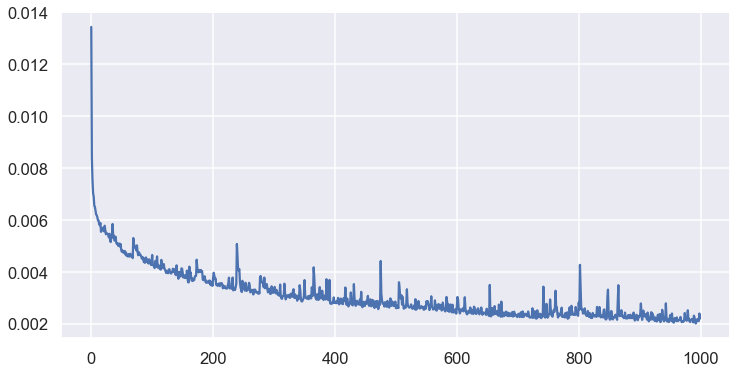

In [31]:
sns.set(context="talk")
fig = plt.subplots(figsize=(12,6))
plt.plot(history3.history['loss'])
loss_data = pd.DataFrame(history4.history)
loss_data[999:]

In [16]:
predict_data = pd.DataFrame(model.predict(X_train_2))
predict_data

,0,1,2
0,-0.130810,0.106971,1.119036
1,0.029673,0.186112,0.959986
2,-0.135718,0.204542,0.280078
3,0.114762,0.321176,1.573888
4,0.059320,0.013008,0.778034
...,...,...,...
531,0.166216,-0.024862,0.403524
532,0.174454,0.109143,0.695002
533,-0.029310,0.168829,0.548453
534,0.017980,0.091674,0.664463


In [17]:
def adjust_learning_data(data):
    predict_data = pd.DataFrame(model.predict(data))#学習用データの成形
    df_model_data = pd.DataFrame({'Gate': predict_data[0], 'Step':  predict_data[1], 'Key':0,'Tgate': 0, 'Tstep': 0, 'Dyn':0, 'Velo': predict_data[2] },
                            columns=['Key','Tgate', 'Tstep', 'Dyn', 'Velo','Gate','Step'])#目的変数に合わせる

    return df_model_data

# 教師データ１の学習結果

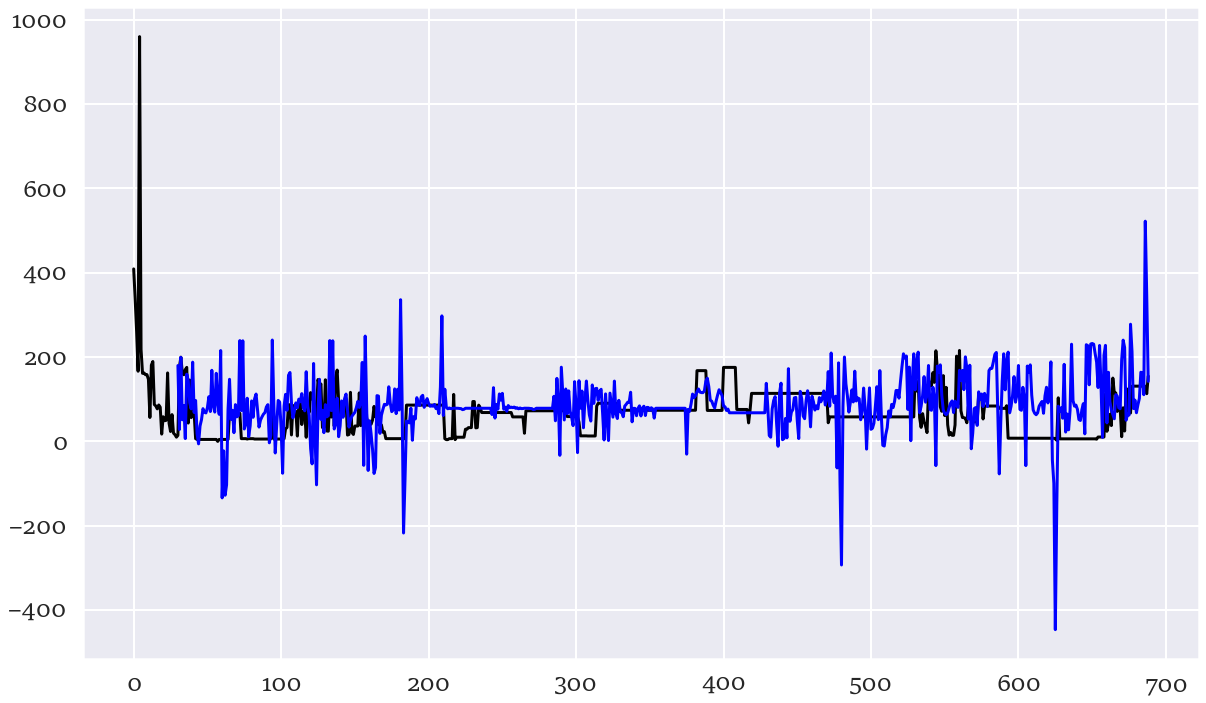

In [18]:
sns.set(context="poster",font="Sitka Small")
fig = plt.subplots(figsize=(20,12))

#正解のプロット
df = pd.DataFrame(scaler.inverse_transform(df_scale_1),
                       index=df_1.index,columns=df_1.columns)
plt.plot(df[0:]["Gate"],color="black")

#学習用データ予測結果のプロット
df_model_train_1 = adjust_learning_data(X_train_1)
df_train_pred_1 = pd.DataFrame(scaler.inverse_transform(df_model_train_1),
                                  index=df_scale_1.index[look_back:],columns=df_scale_1.columns)
plt.plot(df_train_pred_1[0:]["Gate"],color="blue")


# 推論結果

,Key,Tgate,Tstep,Dyn,Velo,Gate,Step
0,80.0,120.0,120.0,72.0,111.0,215.0,102.00000
1,78.0,120.0,120.0,72.0,90.0,129.0,102.00000
2,76.0,120.0,120.0,72.0,90.0,144.0,102.99996
3,75.0,120.0,120.0,72.0,90.0,102.0,102.00000
4,85.0,120.0,120.0,72.0,90.0,20.0,92.00004
...,...,...,...,...,...,...,...
941,61.0,120.0,120.0,112.0,67.0,83.0,83.00004
942,64.0,120.0,1440.0,112.0,60.0,60.0,996.00048
943,85.0,240.0,840.0,112.0,67.0,75.0,525.00000
944,61.0,120.0,120.0,112.0,68.0,56.0,78.00000


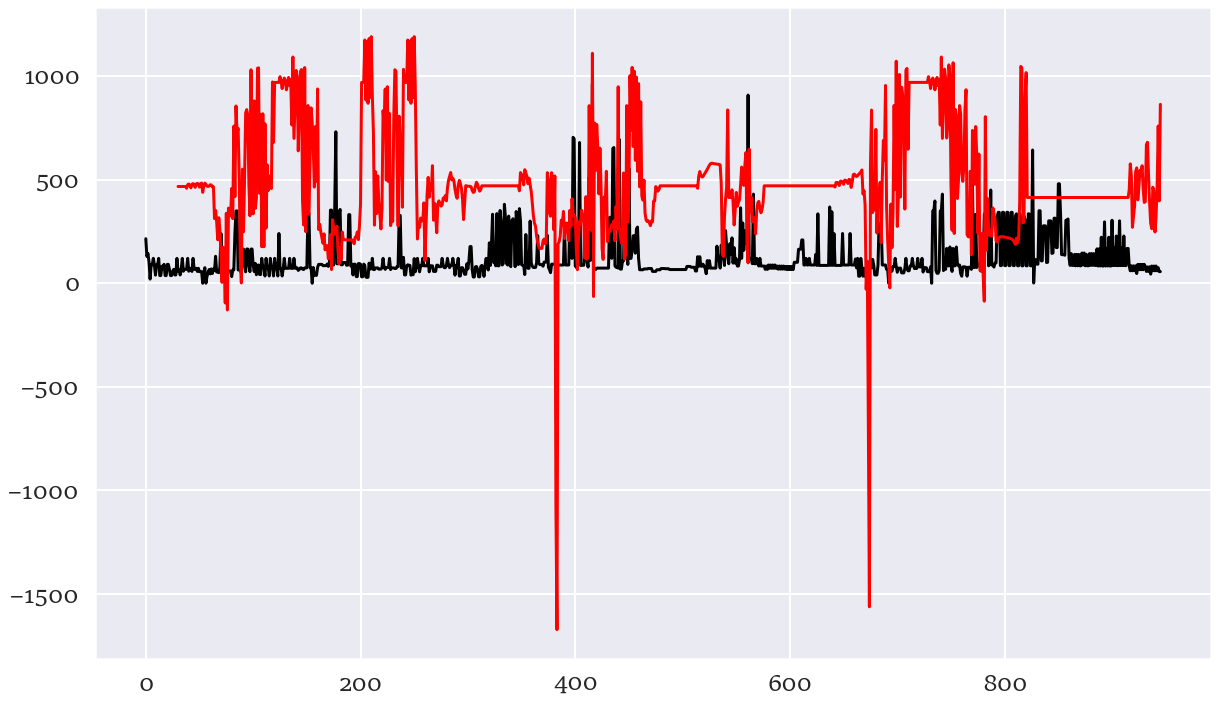

In [33]:
sns.set(context="poster",font="Sitka Small")
fig = plt.subplots(figsize=(20,12))

#正解のプロット
df_test = pd.DataFrame(scaler.inverse_transform(df_scale_6),
                       index=df_6.index,columns=df_6.columns)
plt.plot(df_test[0:]["Gate"],color="black")

#評価用データ予測結果のプロット
df_model_test = adjust_learning_data(X_pre)
df_test_pred = pd.DataFrame(scaler.inverse_transform(df_model_test),
                                 index=df_scale_6.index[look_back:],columns=df_scale_6.columns)
plt.plot(df_test_pred[0:]["Gate"],color="red")
df_test


# PDF出力

In [21]:
df_test_pred.to_csv(r"C:\\Users\\hayashi\\Desktop\\\Pre_Chopin_Etude_Op._10_No._4_C_MinorTorrent.csv",encoding='utf-8')